## Resource Management

In this tutorial, we will show how to use ``IBMQPUSelectors`` to automate the process of selecting which qubits will be used. We will illustrate how the selectors might be used within a 4-step Qiskit Pattern. For more information on ``Qiskit Patterns`` and how ``Quantum Serverless`` can be used to deploy them to the cloud for managed execution, visit our [docs page on the IBM Quantum Platform](https://docs.quantum-computing.ibm.com/run/quantum-serverless).

##### First, let's take a look at all of the backends available to us via Qiskit Runtime. We will ignore all simulators.

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

for backend in service.backends(simulator=False):
    print(
        f"Backend name: {backend.name}    ",
        f"Status: {backend.status().status_msg}    ",
        f"Operational: {backend.status().operational}    ",
        f"Queue size: {backend.status().pending_jobs}    ",
        f"# qubits: {backend.num_qubits}",
    )

Backend name: ibm_brisbane     Status: active     Operational: True     Queue size: 901     # qubits: 127
Backend name: ibm_cusco     Status: active     Operational: True     Queue size: 235     # qubits: 127
Backend name: ibm_nairobi     Status: active     Operational: True     Queue size: 40     # qubits: 7
Backend name: ibm_sherbrooke     Status: active     Operational: True     Queue size: 952     # qubits: 127
Backend name: ibm_lagos     Status: dedicated     Operational: True     Queue size: 31     # qubits: 7
Backend name: ibm_hanoi     Status: active     Operational: True     Queue size: 20     # qubits: 27
Backend name: ibm_perth     Status: dedicated     Operational: True     Queue size: 528     # qubits: 7
Backend name: ibm_algiers     Status: active     Operational: True     Queue size: 43     # qubits: 27
Backend name: ibm_cairo     Status: internal     Operational: True     Queue size: 18     # qubits: 27
Backend name: ibm_nazca     Status: active     Operational: True   

### Build the Qiskit Pattern

We will implement our pattern using the four steps outlined in the [docs](https://docs.quantum-computing.ibm.com/run/quantum-serverless). In this case, we will generate a random circuit and sample from it using the Qiskit Runtime Sampler.

#### Step 1: Map classical inputs to a quantum problem
- Input: Classical parameters to define a circuit
- Output: Abstract circuit

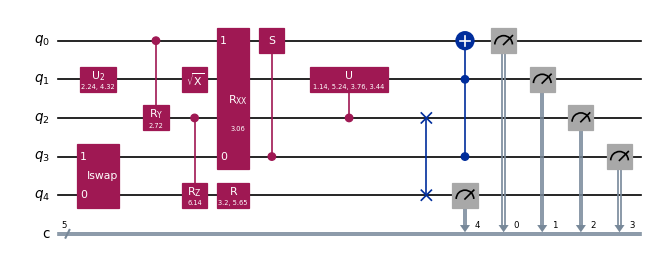

In [2]:
import random
from qiskit.circuit.random import random_circuit

abstract_circuit = random_circuit(
    num_qubits=5, depth=4, measure=True, seed=random.randint(0, 1000)
)
abstract_circuit.draw("mpl", scale=0.6, style="iqp")

#### Step 2: Optimize problem for quantum execution

Instead of manually selecting a backend, we will use the QPU selectors from Quantum Serverless to automatically allocate a backend according to desired criteria. First, we will use ``IBMLeastNoisyQPUSelector`` selector to find a backend, from the ones available to a given user through their IBM Quantum account, that yields the least-noisy qubit subgraph for the input circuit.

We could also use the ``IBMLeastBusyQPUSelector`` to find a backend that can support our circuit width but with the shortest queue.

- Input: Abstract circuit
- Output: Target circuit transpiled to an automatically selected backend

Selected backend: ibm_brisbane


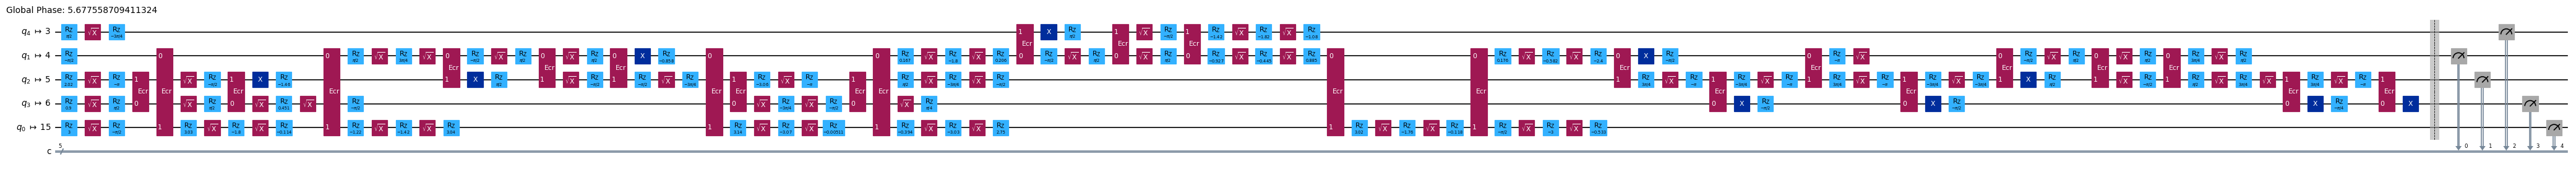

In [3]:
from quantum_serverless_tools.selectors import IBMLeastNoisyQPUSelector

selector = IBMLeastNoisyQPUSelector(
    service, circuit=abstract_circuit, transpile_options={"optimization_level": 3}
)
backend = selector.get_backend()
target_circuit = selector.optimized_circuit

## Alternatively, one can automatically select a backend according to most available:
# from qiskit import transpile
# from quantum_serverless_tools.selectors import IBMLeastBusyQPUSelector
#
# backend = IBMLeastBusyQPUSelector().get_backend()
# target_circuit = transpile(abstract_circuit, backend)

print(f"Selected backend: {backend.name}")
target_circuit.draw("mpl", idle_wires=False, scale=0.6, style="iqp", fold=-1)

#### Step 3: Execute using Qiskit Runtime Primitives

Execute the target circuit on the backend chosen by the selector. Since we optimized our circuit for the backend in step 2, we can skip transpilation in the primitives by setting ``skip_transpilation=True``.

- Input: Target circuit
- Output: Quasi-probability distribution

In [5]:
from qiskit_ibm_runtime import Session, Sampler, Options

with Session(service, backend=backend) as session:
    sampler = Sampler(
        options=Options(
            execution={"shots": 1024}, transpilation={"skip_transpilation": True}
        )
    )
    quasi_dists = sampler.run(target_circuit).result().quasi_dists[0]

print(f"Sampled {len(quasi_dists.items())} unique bitstrings.")

Sampled 3 unique bitstrings.


#### Step 4: Post-process, return result in classical format

- Input: Quasi-probability distribution
- Output: Post-processed solution

In [6]:
def postprocess():
    return "Postprocess and return solution."

### Deploy and Run the Qiskit Pattern
To deploy and run this Qiskit Pattern on the cloud with Quantum Serverless, please see the [documentation](https://docs.quantum-computing.ibm.com/run/quantum-serverless).